In [188]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [189]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, RepeatVector, TimeDistributed, Dropout
import seaborn as sns
import yfinance as yf

In [190]:
ticker = "NVDA"
start_date = "2024-06-02"
end_date = "2025-15-01"

data = yf.download(ticker, start=start_date, end=end_date)
data.to_csv(f"{ticker}data.csv")

print(f"Stock data for {ticker} downloaded and saved as '{ticker}data.csv'.")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NVDA']: ValueError("time data '2025-15-01' does not match format '%Y-%m-%d'")


Stock data for NVDA downloaded and saved as 'NVDAdata.csv'.


In [191]:
data = pd.read_csv("NVDAdata.csv")

In [192]:
data.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
data.shape

(2, 7)

In [194]:
data = data.drop(data.index[[0,1]])
data = data.reset_index(drop=True)

In [195]:
data

,Price,Adj Close,Close,High,Low,Open,Volume


In [ ]:
data.columns = ['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
data.head()

ValueError: Length mismatch: Expected axis has 7 elements, new values have 6 elements

In [162]:
df = data[['Date', 'Close']]


In [163]:
df.head()

,Date,Close
0,2024-01-02,48.15434646606445
1,2024-01-03,47.55551528930664
2,2024-01-04,47.984397888183594
3,2024-01-05,49.08308029174805
4,2024-01-08,52.23818588256836


In [164]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df[['Close']].values)

In [165]:
seq_len = 50

In [166]:
def sequence(data, seq_len):
    X = []
    for i in range(len(data) - seq_len):
        X.append(data[i:(i + seq_len), 0])
    return np.array(X)

In [167]:
X = sequence (scaled_df, seq_len)

In [168]:
X_train, X_test = train_test_split(X, test_size=0.3, shuffle=False)

In [169]:
X_train.shape

(67, 50)

In [170]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [171]:
X_train.shape, X_test.shape

((67, 50, 1), (29, 50, 1))

In [ ]:
model = Sequential([
      LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
      Dropout(0.2),
      RepeatVector(X_train.shape[1]),
      LSTM(64, return_sequences=True),
      TimeDistributed(Dense(1))
    ])

/data/selvaraju/anaconda3/envs/env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [173]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 50, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [174]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X_train, X_train, epochs=10, batch_size=32, validation_data= (X_test, X_test))

Epoch 1/10


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - loss: 0.2096 - val_loss: 0.2507
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0685 - val_loss: 0.0327
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0181 - val_loss: 0.0472
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0335 - val_loss: 0.0293
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0165 - val_loss: 0.0582
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0190 - val_loss: 0.0749
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0211 - val_loss: 0.0679
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0185 - val_loss: 0.0496
Epoch 9/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0152 - val_loss: 0.0361
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0160 - val_loss: 0.0314


In [ ]:
reconst_train = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


In [ ]:
reconst =  model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [178]:
reconst_train_error = np.mean(np.abs(reconst_train - X_train), axis=(1,2))

In [179]:
reconst_error = np.mean(np.abs(reconst - X_test), axis=(1,2))

(array([ 8., 20.,  4.,  2.,  1.,  2.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
         2.,  4.,  2.,  4.,  2.,  2.,  2.]),
 array([0.05019995, 0.05669864, 0.06319733, 0.06969602, 0.07619471,
        0.0826934 , 0.08919208, 0.09569077, 0.10218946, 0.10868815,
        0.11518684, 0.12168553, 0.12818422, 0.13468291, 0.1411816 ,
        0.14768029, 0.15417898, 0.16067767, 0.16717636, 0.17367505,
        0.18017374]),
 <BarContainer object of 20 artists>)

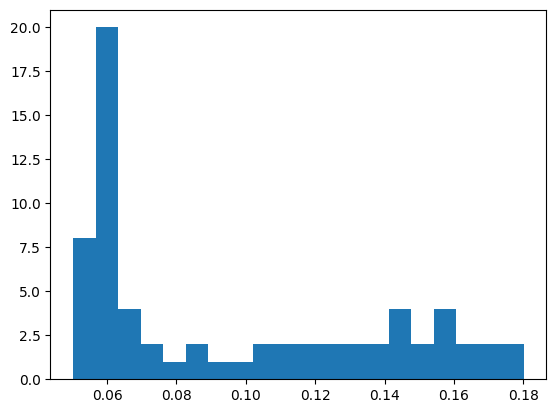

In [ ]:
plt.hist(reconst_train_error, bins = 20)

(array([5., 6., 4., 2., 0., 1., 2., 2., 0., 3., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([0.13734313, 0.14162676, 0.14591039, 0.15019402, 0.15447765,
        0.15876127, 0.1630449 , 0.16732853, 0.17161216, 0.17589579,
        0.18017942, 0.18446304, 0.18874667, 0.1930303 , 0.19731393,
        0.20159756, 0.20588118, 0.21016481, 0.21444844, 0.21873207,
        0.2230157 ]),
 <BarContainer object of 20 artists>)

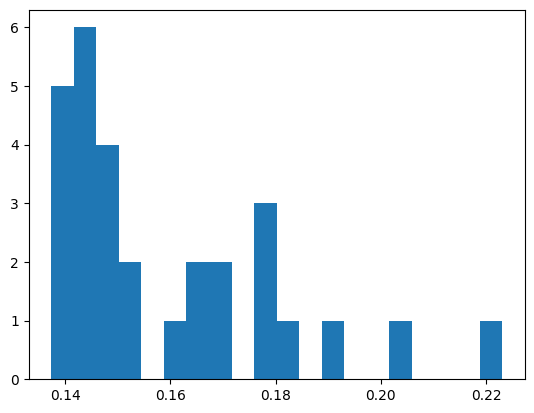

In [181]:
plt.hist(reconst_error, bins = 20)

In [182]:
thresh = np.percentile(reconst_error, 95)


In [183]:
anom = reconst_error > thresh

In [184]:
# Limit decimal places to 4
reconst_train_error = np.round(reconst_train_error, 4)
reconst_error = np.round(reconst_error, 4)


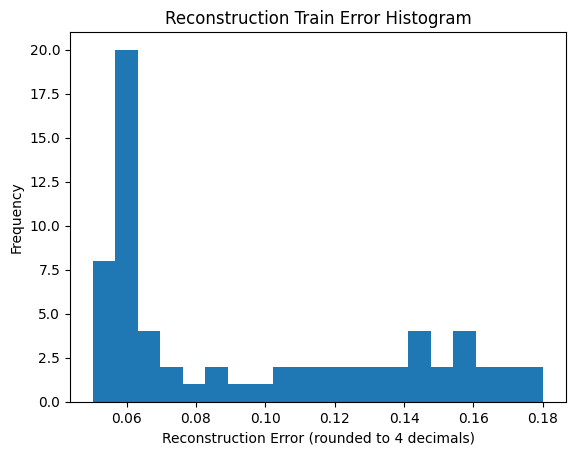

In [ ]:
plt.hist(reconst_train_error, bins=20)
plt.title('Reconstruction Train Error Histogram')
plt.xlabel('Reconstruction Error (rounded to 4 decimals)')
plt.ylabel('Frequency')
plt.show()


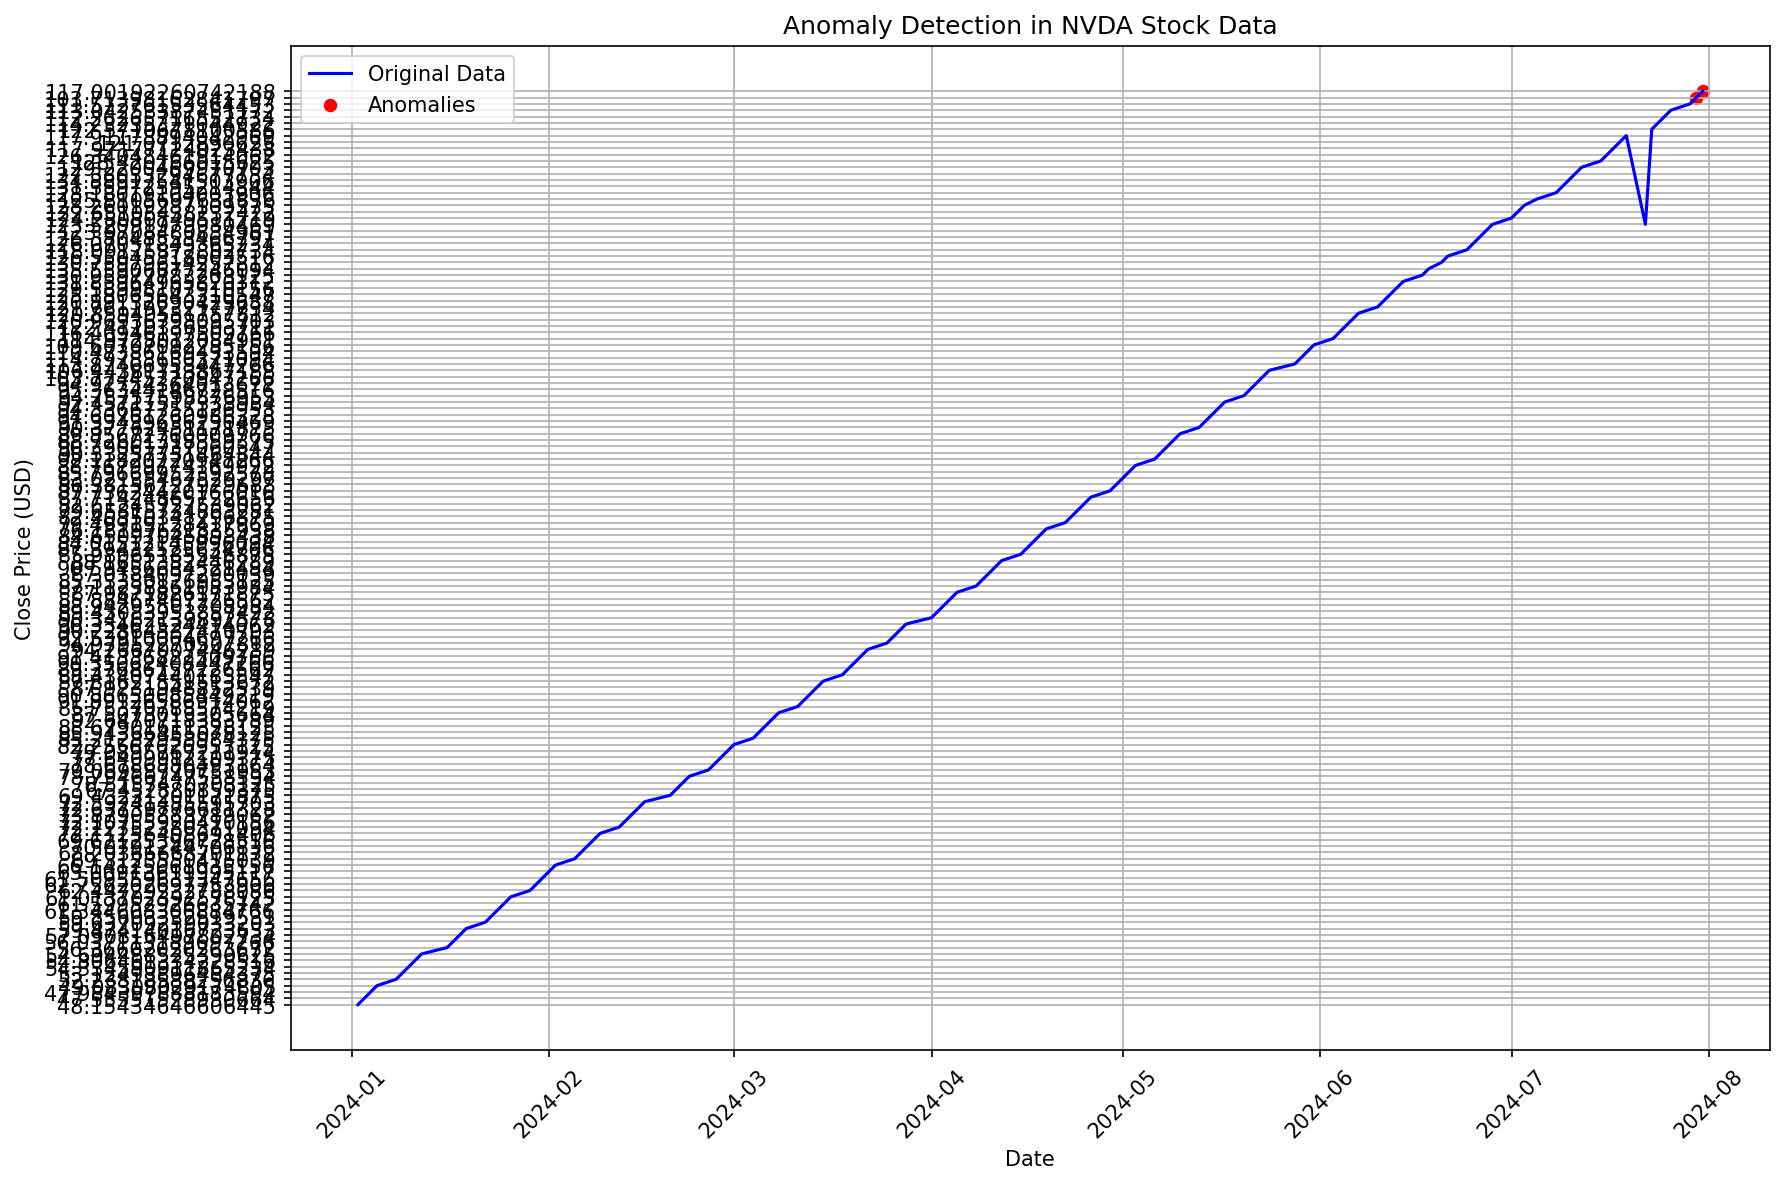

In [186]:
# Ensure Date is datetime
data['Date'] = pd.to_datetime(data['Date'])

# Create a placeholder for anomalies
anomaly_indices = np.arange(len(scaled_df) - len(X_test), len(scaled_df))[anom]  # Map anomalies to original data indices

# Extract anomaly rows from the original DataFrame
anomalies = data.iloc[anomaly_indices]

# Plot original data
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(data['Date'], data['Close'], label='Original Data', color='blue')

# Highlight anomalies
if not anomalies.empty:  # Check if anomalies exist
    plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='Anomalies', s=30)

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.title('Anomaly Detection in NVDA Stock Data')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
